## Email Text Classification (K-Means and Topic Modeling/LDA)

We performed email text classification, by using K-Means and topic Modeling (LDA), results show that some of classified contents are similar.  

In [1]:
# Import library and read csv
import pandas as pd
import numpy as np
import numpy as np
import string
import nltk
import gensim
from gensim import corpora
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns

In [2]:
emails = pd.read_csv('emails.csv')
print(emails.shape)
email_subset = emails[:20000]
print(email_subset.shape)
print(email_subset.head())

(517401, 2)
(20000, 2)
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
email_subset['message'].loc[5].split('\n')

['Message-ID: <30965995.1075863688265.JavaMail.evans@thyme>',
 'Date: Thu, 31 Aug 2000 04:17:00 -0700 (PDT)',
 'From: phillip.allen@enron.com',
 'To: greg.piper@enron.com',
 'Subject: Re: Hello',
 'Mime-Version: 1.0',
 'Content-Type: text/plain; charset=us-ascii',
 'Content-Transfer-Encoding: 7bit',
 'X-From: Phillip K Allen',
 'X-To: Greg Piper',
 'X-cc: ',
 'X-bcc: ',
 "X-Folder: \\Phillip_Allen_Dec2000\\Notes Folders\\'sent mail",
 'X-Origin: Allen-P',
 'X-FileName: pallen.nsf',
 '',
 'Greg,',
 '',
 ' How about either next Tuesday or Thursday?',
 '',
 'Phillip']

In [4]:
def parse_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [5]:
email_df = pd.DataFrame([i for i in [parse_message(m) for m in email_subset['message']]])
display(email_df.sample(5))
print(email_df.shape)

,from,to,body
19942,kayne.coulter@enron.com,"jay.wills@enron.com, cyril.price@enron.com, jo...","rudy.acevedo@enron.com, richard.hrabal@enron.c..."
12000,eric.bass@enron.com,"""'Eric_Bass@enron.com'"" <Eric_Bass@enron.com>",Michael is a happily married man. He would ne...
18349,news@luxurylink.com,don.baughman@enron.com,"Buenos Aires, Barbados, Indian Wells, Bali, Pa..."
12372,Eric.Bass@enron.com [mailto,"Bass, Jason",i havent heard anything yet - i will let you k...
12985,eric.bass@enron.com,eric preston bass <Eric.Bass@enron.com>,beef and bird is on wilcrest - right?Hi Son. M...


(20000, 3)


In [6]:
# Check null values
email_df.isnull().all()

from    False
to      False
body    False
dtype: bool

### Text Cleaning

In [8]:
# Define stopwords to exclude
nltk.download('stopwords')
stop = set(stopwords.words('english'))
stop.update(("to", "cc", "subject", "http", "from", "sent", "ect", "u", "fwd", "www", "com", 'html'))
# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sealion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

# Import the lemmatizer from nltk
lemma = WordNetLemmatizer()

def clean(text):
    text = str(text).rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized
# Clean the emails in email_df and print results
text_clean=[]
for text in email_df['body']:
    text_clean.append(clean(text).split())    
text_clean[1][:5]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sealion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['traveling', 'business', 'meeting', 'take', 'fun']

In [10]:
email_df['clean_text'] = email_df['body'].apply(clean)
email_df.head(5)

,from,to,body,clean_text
0,phillip.allen@enron.com,tim.belden@enron.com,Here is our forecast,forecast
1,phillip.allen@enron.com,john.lavorato@enron.com,Traveling to have a business meeting takes the...,traveling business meeting take fun trip espec...
2,phillip.allen@enron.com,leah.arsdall@enron.com,test successful. way to go!!!,test successful way go
3,phillip.allen@enron.com,randall.gay@enron.com,"Randy,Can you send me a schedule of the salary...",randycan send schedule salary level everyone t...
4,phillip.allen@enron.com,greg.piper@enron.com,,


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', max_df=0.75, min_df=1, ngram_range=(1,3), max_features=1000)
new_vect = vect.fit_transform(email_df['clean_text'])

In [12]:
## To find out the top keywords in the email
row = np.squeeze(new_vect[1].toarray())
features = vect.get_feature_names()
top_feature = [(features[i], row[i]) for i in np.argsort(row)[::-1][:10]]
top_feature
pd.DataFrame(top_feature, columns = ['features', 'score'])

C:\Users\Sealion\anaconda3\envs\python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,features,score
0,meeting,0.543749
1,business,0.411307
2,trip,0.396988
3,discussion,0.278341
4,try,0.229640
5,jet,0.155166
6,table,0.149227
7,austin,0.147740
8,especially,0.139708
9,fun,0.134621


## (1). K-Means

C:\Users\Sealion\anaconda3\envs\python\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


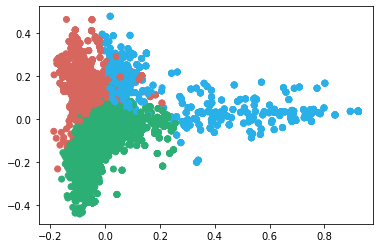

In [13]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=3, max_iter=100, init='k-means++', random_state = 42)
labels = clf.fit_predict(new_vect)

label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
coords = PCA(n_components=2).fit_transform(new_vect.todense())
plt.scatter(coords[:, 0], coords[:, 1], c=colors)
plt.show()

In [15]:
## To extract the top terms per cluster
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

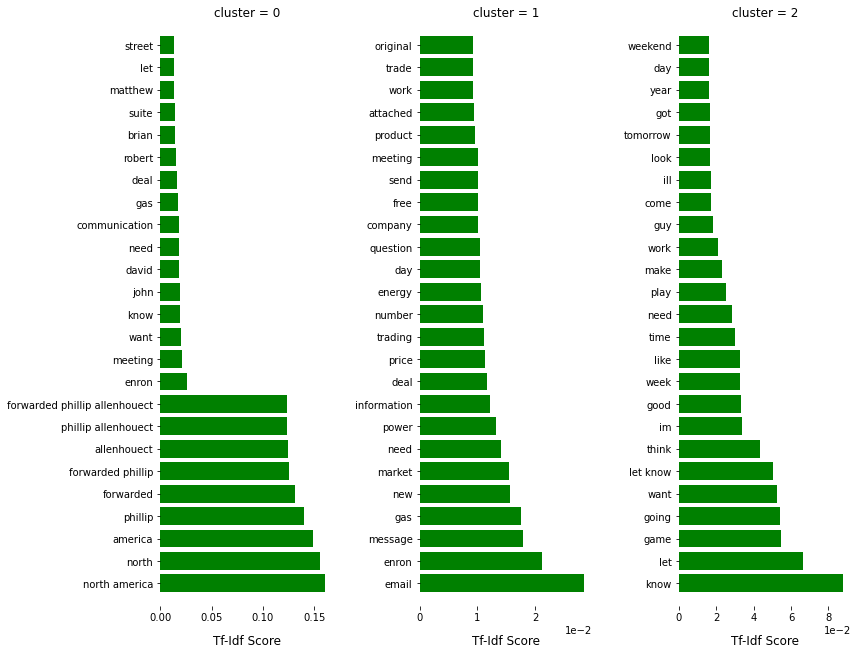

In [16]:
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=12, fontsize=12)
        ax.set_title("cluster = " + str(df.label), fontsize=12)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='g')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.1, right=1, left=0.2, top=1, wspace=0.5)
    plt.show()    
plot_tfidf_classfeats_h(top_feats_per_cluster(new_vect, labels, features, 0.1, 25))

In [17]:
## Query the key word (example)
query = "forwarded phillip"
vec_query = vect.transform([query])
cosine_sim = linear_kernel(vec_query, new_vect).flatten()
related_email_indices = cosine_sim.argsort()[:-10:-1]
print(related_email_indices)

[15190 14694 12039  2498  1086   551  1690   137   357]


In [18]:
# Show the example
display(email_df.iloc[551].body)

'---------------------- Forwarded by Phillip K Allen/HOU/ECT on 11/29/2000Anne Bike@ENRONSanchez/HOU/ECT@ECT, Phillip K Allen/HOU/ECT@ECTAttached please find the spreadsheet containing the above referencedinformation.'

## (2). Latent Dirichlet Allocation (LDA) topic modeling

In [46]:
# Dictionary and corpus
dictionary = corpora.Dictionary(text_clean)
# Filter out (non)frequent words 
# dictionary.filter_extremes(no_below=10, keep_n=500000)
corpus = [dictionary.doc2bow(text) for text in text_clean]
print(dictionary)

Dictionary(174912 unique tokens: ['forecast', 'across', 'austin', 'better', 'boat']...)


In [41]:
# LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
# Top words for each topic
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.006*"enron" + 0.006*"company" + 0.005*"power" + 0.005*"said" + 0.005*"market"')
(1, '0.008*"facearial" + 0.005*"border0" + 0.004*"cellspacing0" + 0.003*"john" + 0.003*"david"')
(2, '0.008*"image" + 0.006*"new" + 0.005*"email" + 0.004*"please" + 0.004*"travel"')
(3, '0.011*"game" + 0.009*"week" + 0.006*"get" + 0.005*"updated" + 0.005*"last"')
(4, '0.014*"email" + 0.011*"please" + 0.007*"alignrightfont" + 0.006*"message" + 0.006*"enron"')


### Visualize the topics

In [43]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\Sealion\anaconda3\envs\python\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [4]:
from IPython.display import Image
Image(url= "topic_modeling.jpg", width=700, height=700)

In [ ]:
# Evaluation of model
Perplexity_score = ldamodel.log_perplexity(corpus, total_docs = 20000)
print('Perplexity: ', nPerplexity_score)  ## Measurement of quality of model, the lower the better.

from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_clean, dictionary=dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
Perplexity:  -9.383315865452136
Coherence Score:  0.5040865181201668

## Conclusion: 
The classified contents are similar between cluster 1 (K-Means model) and topic 1 (LDA model) , which is about company, market, trading, market, energy, gas, business, stock and etc..

#### References:
    1. Kaggle
    2. Medium
    3. Data camp
https://www.datacamp.com/community/tutorials/lda2vec-topic-model

https://medium.datadriveninvestor.com/nlp-with-lda-analyzing-topics-in-the-enron-email-dataset-20326b7ae36f

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/